### Routing
- Routing in LangGraph is about controlling which path the graph takes next based on the current state or conditions. Think of it like decision-making inside your workflow.
- Routing = deciding which node to execute next.
- Controlled by edges between nodes.
- Two main types:
    1. Normal Edges → always go from one node to the next (add_edge).
    2. Conditional Edges → choose the next node based on a condition function (add_conditional_edges).
- Routing is super useful in real-world cases like:
    - If no documents are retrieved → route to “human_review”.
    - If confidence < threshold → route to “fallback_model”.
    - If query type = “FAQ” → route to pre-defined answers node, else → LLM node.
- Why Routing Matters
    - Adds intelligence to workflows (not just linear).
    - Makes agents more adaptive.
    - Handles edge cases gracefully (e.g., low confidence → ask human).
    - Enables multi-path workflows (retrieval vs generation vs rules).

In [3]:
# imports and load LLM
import os
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
api_key = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(name="gpt-5-nano", api_key=api_key)
llm.invoke("What is machine learning?")

AIMessage(content='Machine learning is a subset of artificial intelligence that involves the development of algorithms and models that enable computers to learn from and make predictions or decisions based on data, without being explicitly programmed to do so. In other words, it is a method of teaching computers to learn and improve from experience, rather than being pre-programmed with specific rules. Machine learning algorithms can analyze large amounts of data to identify patterns, make predictions, and make decisions with minimal human intervention.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 12, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CZyg2hB5XtEp6

c:\MyDrive\SelfStudyCode\AI\Krish\AgenticAI\venv\lib\site-packages\langchain_openai\chat_models\base.py:1906: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


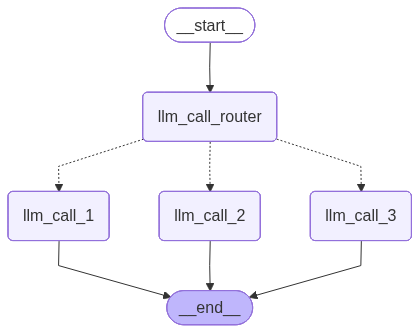

In [4]:
# Define state
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(description="The next step in the routing process")

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

# State
class State(TypedDict):
    input: str
    decision: str
    output: str

# Create nodes
def llm_call_router(state: State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to the story, joke or poem based on the user's request."
            ),
            HumanMessage(
                content=state['input']
            )
        ]
    )
    return {'decision': decision.step}

def llm_call_1(state: State):
    """Write a story"""
    msg = llm.invoke(state['input'])
    return {'output': msg.content}

def llm_call_2(state: State):
    """Write a joke"""
    msg = llm.invoke(state['input'])
    return {'output': msg.content}

def llm_call_3(state: State):
    """Write a poem"""
    msg = llm.invoke(state['input'])
    return {'output': msg.content}

def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

# Build graph
graph = StateGraph(State)
graph.add_node("llm_call_router", llm_call_router)
graph.add_node("llm_call_1", llm_call_1)
graph.add_node("llm_call_2", llm_call_2)
graph.add_node("llm_call_3", llm_call_3)

# Create edges
graph.add_edge(START, "llm_call_router")
graph.add_conditional_edges("llm_call_router",
                            route_decision,
                            {
                                "llm_call_1": "llm_call_1",
                                "llm_call_2": "llm_call_2",
                                "llm_call_3": "llm_call_3"
                            }
                        )
graph.add_edge("llm_call_1", END)
graph.add_edge("llm_call_2", END)
graph.add_edge("llm_call_3", END)

# Compile graph
compiled_graph = graph.compile()

# View graph
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [5]:
compiled_graph.invoke({"input": "Write a joke about agentic AI system"})

{'input': 'Write a joke about agentic AI system',
 'decision': 'joke',
 'output': "Why did the agentic AI system go to therapy?\n\nBecause it had too many issues and couldn't compute them all!"}